## Project 1: Gradient-based Algorithms and Differentiable Programming
### Problem formulate
In this project, we add three different aspects to make the problem become more reality:

1. Add drag force for the dynmical function
2. Consider the distribtuion of initial state
3. Add noise in the state and dynamic

To simplify the model, we assume that the rocket lands on the ground in the vertical direction, which we need to consider gravity, thrust and drag. The below figure shows the rocket motion and force frame. We can easily know that the state and dynamic function should be
$$
\begin{aligned}
\quad &x_{t+1} = x_{t} + v_{t}\Delta t + w_{t} \\
\quad &v_{t+1} = v_{t} + (g_{gravity} + (a_{drag}-a_{thrust})a_{t})\Delta t + u_{t} \\
\quad &a_{t} = NN_{\theta}(x_{t})
\end{aligned}
$$
where $x_{t}$ is the rocket position at current time $t$, $v_{t}$ is the rocket speed at current time $t$, $g_{gravity}$ is the gravity acceleartion, $a_{drag}$ is the drag constant, $a_{thrust}$ is the thrust constant, $w_{t}$ and $u_{t}$ are the noise for state and dynamic function at the current time $t$ respectively. $a_{t}$ is the action output from neural network which is feed by $x_{t}$, $\theta$ is the parameter of the neural network.

We set the uniform distribution for the initial position and keep all the initial speed be eqaul to 0. The range of distribution is $[1, 2.5]m$. In this experiment, we randomly choose 30 initial state from its distribution.

We set the objective function, which is
$$
\begin{aligned}
\quad &f = x_{T}^2 + v_{T}^2
\end{aligned}
$$
where $T$ is the final time when the rocket lands on the ground.

Hence, we need to minimize the objective function based on initial state distribution
$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}_{T} + v^{(i)}_{T}||^2 \\
\quad &x^{(i)}_{t+1} = x^{(i)}_{t} + v^{(i)}_{t}\Delta t + w^{(i)}_{t} \\
\quad &v^{(i)}_{t+1} = v^{(i)}_{t} + (g_{gravity} + (a_{drag}-a_{thrust})a^{(i)}_{t})\Delta t + u^{(i)}_{t} \\
\quad &a_{t}^{(i)} = NN_{\theta}(x^{(i)}_{t}), \forall t=1,...,T-1, \forall i=1,...,N\\
\quad & T = 100, N = 30\\
\end{aligned}
$$

![Image](https://github.com/dayanbatuofu/MAE-598-Design-Optimization/raw/main/rocket%20landing.png)

### Programming detail

In [1]:
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters

PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.06  # landing platform height
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
ROTATION_ACCEL = 20  # rotation constant
DRAG_ACCEL = 0.005  # drag constant

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action, Noise, mean, variance):
        """
        action: thrust or not thrust
        state[0] = y
        state[1] = y_dot
        """
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust and drag
        delta_state = (DRAG_ACCEL - BOOST_ACCEL) * FRAME_TIME * t.tensor([0., 1.]) * action

        # Noise
        w = t.tensor([1, 0]) * t.tensor(np.random.normal(mean, variance, 1))
        u = t.tensor([0, 1]) * t.tensor(np.random.normal(mean, variance, 1))
        noise = w + u

        # Update velocity
        state = state + delta_state + delta_state_gravity

        # Update state
        step_mat = t.tensor([[1., 0.],
                             [FRAME_TIME, 1.]])
        if Noise == True:
            state = t.matmul(state, step_mat) + noise.float()
        else:
            state = t.matmul(state, step_mat)

        return state

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()
        # little linear network with ReLU for embeddings
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, is_Noise, mean, variance):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        self.is_Noise = is_Noise
        self.mean = mean
        self.variance = variance

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action, self.is_Noise, self.mean, self.variance)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = np.ones((30, 2))
        for i in range(state.shape[0]):
            state[i][0] = np.random.uniform(1, 2.5, 1)
            state[i][1] = 0
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return t.mean(state ** 2)

class Optimize:

    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        print()

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][j].detach().numpy() for i in range(self.simulation.T)] for j in range(30)])
        for i in range(30):
            x = data[i, :, 0]
            y = data[i, :, 1]
            plt.plot(x, y)
        plt.title('Position and Velocity Changeable for Rocket Landing')
        plt.xlabel('Rocket Position(m)')
        plt.ylabel('Rocket Velocity(m/s)')
        plt.show()

### Result and Discussion
Firstly, we consider the state and dynamic function without noise. The aim of objective function is to guarantee that the rocket can land on the ground when reaching the final time, which means that the final positon of the rocket should be eqaul to 0. Besides, the final speed of the rocket should be approximate to 0. The below figure shows the trajectory for rocket position and velocity. We can find the curves can arrive at 0 on the X axis and be close to 0 on the Y axis, which means that the controller can meet the requirement of the design.  


[1] loss: 4.338
[2] loss: 2.367
[3] loss: 1.221
[4] loss: 0.719
[5] loss: 0.445
[6] loss: 0.255
[7] loss: 0.168
[8] loss: 0.124
[9] loss: 0.093
[10] loss: 0.071
[11] loss: 0.061
[12] loss: 0.055
[13] loss: 0.050
[14] loss: 0.043
[15] loss: 0.024
[16] loss: 0.018
[17] loss: 0.014
[18] loss: 0.011
[19] loss: 0.008
[20] loss: 0.007
[21] loss: 0.005
[22] loss: 0.004
[23] loss: 0.004
[24] loss: 0.003
[25] loss: 0.003
[26] loss: 0.003
[27] loss: 0.003
[28] loss: 0.002
[29] loss: 0.002
[30] loss: 0.002
[31] loss: 0.002
[32] loss: 0.002
[33] loss: 0.002
[34] loss: 0.002
[35] loss: 0.002
[36] loss: 0.002
[37] loss: 0.002
[38] loss: 0.002
[39] loss: 0.002
[40] loss: 0.002


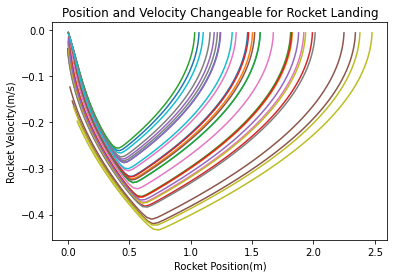

In [2]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = False
mean, variance = (0, 1e-4)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)

Next, we add the noise in the state and dynamic function. We consider the Gaussian Distribution and choose the noise variable randomly from this distribution. Because the noise range (mean is 0, variance is $10^{-4}$) is very small, we speculate that the trajectory might be similar to the case without noise. The below figure supports our hypothesis and result shows that the controller can work well when having a very small disturbance.


[1] loss: 2.821
[2] loss: 1.589
[3] loss: 0.762
[4] loss: 0.394
[5] loss: 0.354
[6] loss: 0.243
[7] loss: 0.228
[8] loss: 0.222
[9] loss: 0.201
[10] loss: 0.154
[11] loss: 0.136
[12] loss: 0.134
[13] loss: 0.125
[14] loss: 0.126
[15] loss: 0.111
[16] loss: 0.105
[17] loss: 0.103
[18] loss: 0.104
[19] loss: 0.063
[20] loss: 0.062
[21] loss: 0.062
[22] loss: 0.061
[23] loss: 0.062
[24] loss: 0.059
[25] loss: 0.059
[26] loss: 0.052
[27] loss: 0.049
[28] loss: 0.021
[29] loss: 0.021
[30] loss: 0.018
[31] loss: 0.015
[32] loss: 11.093
[33] loss: 0.031
[34] loss: 0.020
[35] loss: 0.016
[36] loss: 0.015
[37] loss: 0.014
[38] loss: 0.014
[39] loss: 0.014
[40] loss: 0.013


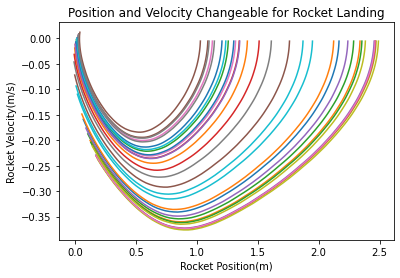

In [3]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = True
mean, variance = (0, 1e-4)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)

We randomly choose one rocket landing trajectory with noise disturbance and present the whole rocket landing process through animation. Animation code is shown as below.   

![Image](https://github.com/dayanbatuofu/MAE-598-Design-Optimization/raw/main/rocket%20landing.gif)

In [ ]:
%matplotlib notebook
import matplotlib.animation as animation
import random
data = np.array([[s.state_trajectory[i][j].detach().numpy() for i in range(s.T)] for j in range(30)])
n = random.sample(list(range(30)), 1)
n[0]
ydata = data[n[0], :, 0]
xdata = np.zeros((ydata.shape[0]))

fig, ax = plt.subplots()
ax.grid()
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    ax.set_xlim(-2, 2)
    ax.set_ylim(0, 3)
    time_text.set_text('')
    return line, time_text

def update(i):
    line.set_data(xdata[i], ydata[i])
    time_text.set_text(time_template % (0.1*i))
    return line, time_text

ani = animation.FuncAnimation(fig, update, frames=range(len(ydata)), init_func=init, interval=50)
ani.save('rocket landing.gif', fps=30)
plt.title('Rocket Landing')
plt.xlabel('Rocket Horizontal Position')
plt.ylabel('Rocket Vertical Position')
plt.show()

We want to test the reliability of the controller when having a large noise disturbance. So we increase variance for the noise distrubiton, which is changed to $10^{-3}$. 


[1] loss: 1.936
[2] loss: 1.348
[3] loss: 0.785
[4] loss: 0.834
[5] loss: 0.848
[6] loss: 0.776
[7] loss: 0.823
[8] loss: 0.874
[9] loss: 0.775
[10] loss: 0.700
[11] loss: 0.823
[12] loss: 0.835
[13] loss: 0.661
[14] loss: 0.821
[15] loss: 0.845
[16] loss: 0.724
[17] loss: 0.771
[18] loss: 0.863
[19] loss: 0.774
[20] loss: 0.714
[21] loss: 0.776
[22] loss: 0.745
[23] loss: 0.772
[24] loss: 0.740
[25] loss: 0.845
[26] loss: 0.791
[27] loss: 0.892
[28] loss: 0.906
[29] loss: 0.670
[30] loss: 0.771
[31] loss: 0.795
[32] loss: 0.898
[33] loss: 0.837
[34] loss: 0.822
[35] loss: 0.832
[36] loss: 0.800
[37] loss: 0.861
[38] loss: 0.730
[39] loss: 0.794
[40] loss: 0.715


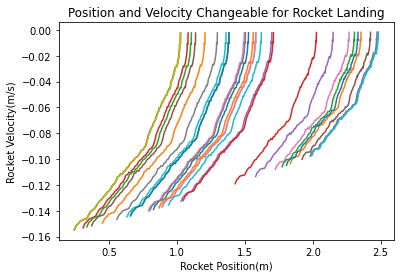

In [4]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
is_Noise = True
mean, variance = (0, 1e-3)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, is_Noise, mean, variance)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)

The curves can not reach 0 on the X aixs when the final time is coming. The results shows that the current controller can not guarantee the design requirment when having a large disturbance. This experiments shows that the curren  